In [ ]:
!pip install global-land-mask
!pip install fastdtw
!pip install haversine
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512574 sha256=b6f7c6c81e2f1820718d3168aa643418b1b2f6f9868f28983c2a7455bbd06a23
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import math
import random
from global_land_mask import globe
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import plotly.express as px

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import requests
from io import StringIO
from geopy.distance import geodesic
from haversine import haversine, Unit

import json
import random
import shutil
import statistics
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
#location spoofer
def calculate_bounding_box(center_lat, center_lon, radius_miles):
    return (
        geodesic().destination((center_lat, center_lon), 0, radius_miles).latitude,
        geodesic().destination((center_lat, center_lon), 90, radius_miles).longitude,
        geodesic().destination((center_lat, center_lon), 180, radius_miles).latitude,
        geodesic().destination((center_lat, center_lon), 270, radius_miles).longitude
    )
def get_random_point_within_bounding_box(bounding_box):
    random_lat = random.uniform(bounding_box[0], bounding_box[2])
    random_lon = random.uniform(bounding_box[1], bounding_box[3])
    return random_lat, random_lon

def get_points_within_radius(center_lat, center_lon, smaller_radius_miles, larger_radius_miles):
    smaller_bounding_box = calculate_bounding_box(center_lat, center_lon, smaller_radius_miles)
    larger_bounding_box = calculate_bounding_box(center_lat, center_lon, larger_radius_miles)

    random_point_within_larger_box = get_random_point_within_bounding_box(larger_bounding_box)

    while (
        smaller_bounding_box[0] <= random_point_within_larger_box[0] <= smaller_bounding_box[2] and
        smaller_bounding_box[1] <= random_point_within_larger_box[1] <= smaller_bounding_box[3]
    ):
        random_point_within_larger_box = get_random_point_within_bounding_box(larger_bounding_box)

    return random_point_within_larger_box

def spoof_location(center_lat, center_lon, smaller_radius_miles, larger_radius_miles):
    for i in range(10):
      lat_spoof, lon_spoof = get_points_within_radius(center_lat, center_lon, smaller_radius_miles, larger_radius_miles)
      if globe.is_land(lat_spoof, lon_spoof):
        return (lat_spoof, lon_spoof)
    return get_points_within_radius(center_lat, center_lon, smaller_radius_miles, larger_radius_miles)

In [ ]:
# center_lat = 42.7284
# center_lon = -73.6918
# smaller_radius_miles = 50
# larger_radius_miles = 400

# for ix in range(5) :
#   result = spoof_location(center_lat, center_lon, smaller_radius_miles, larger_radius_miles)
#   print(f"Count {ix+1} ----> Latitude : {result[0]:.5f} ----> Longitude : {result[1]:.5f}")

# import folium

# latitude = 25.47
# longitude = -112.58


# lon2 = -67.19
# lat2 = 48.94

# lon3 = -82.39
# lat3 = 27.28

# map_center1 = [latitude, longitude]
# map_center2 = [lat2, lon2]
# map_center3 = [lat3, lon3]
# my_map = folium.Map(location=map_center1, zoom_start=10)
# my_map = folium.Map(location=map_center2, zoom_start=10)
# my_map = folium.Map(location=map_center3, zoom_start=10)
# folium.Marker(location=map_center1, popup="Given Location").add_to(my_map)
# folium.Marker(location=map_center2, popup="Given Location").add_to(my_map)
# folium.Marker(location=map_center3, popup="Given Location").add_to(my_map)

# my_map


In [ ]:
#dataset and model classes for verification model

class TreeRingDataset(Dataset):

  _cache = None
  _train = None
  _test = None
  _validate = None

  def __init__(self, set_type="train", transform = None):

    if TreeRingDataset._cache is None:
      res = requests.get("https://paleo-data.s3.amazonaws.com/data.csv")
      TreeRingDataset._cache = pd.read_csv(StringIO(res.text), sep=",")

    res = requests.get("https://paleo-data.s3.amazonaws.com/main_weather.csv")
    self.W_df = pd.read_csv(StringIO(res.text), sep=",")
    self.W_df.drop_duplicates(subset = ['year', 'lat', 'lon'],
                                          inplace = True,
                                          ignore_index = True)

    self.df = TreeRingDataset._cache.copy()

    self.df.drop(self.df.columns[list(range(1, 1940))], axis=1, inplace=True)
    self.df.dropna(subset=self.df.columns[1:52], how='any', inplace=True)

    if type(TreeRingDataset._train) == type(None):
      print("Performing a Split")
      TreeRingDataset._train, TreeRingDataset._test, TreeRingDataset._validate = self.__split()

    self.df = TreeRingDataset._train if set_type == "train" else (TreeRingDataset._test if set_type == "test" else TreeRingDataset._validate)

  def __split(self):
    train, test = train_test_split(self.df, train_size=.70)
    validate, test = train_test_split(test, train_size=.5)
    return (train, test, validate)

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):
    x = torch.tensor(self.df.iloc[index, 1:52].ffill().bfill())
    latn, lats, lone, lonw = self.df.iloc[index, 87:91]
    # lat = (latn+lats)/2
    # lon = (lone+lonw)/2
    lat = latn
    lon = lone

    #print(lat, lon)

    if random.random() > 0.5:
      other_locations = self.W_df[['lat','lon']][(self.W_df['lat'] != lat) & (self.W_df['lon'] != lon)]
      unique_locations = other_locations.drop_duplicates()
      spoof_location = unique_locations.sample(n=1)
      label = 0
      lat = spoof_location['lat'].iloc[0]
      lon = spoof_location['lon'].iloc[0]

    else:
      label = 1

    #print(lat, lon)


    weather_data = self.W_df[(self.W_df['lat'] == lat) & (self.W_df['lon'] == lon)]

    temp = torch.tensor(weather_data['temperature_avg'].values)
    precip = torch.tensor(weather_data['precipitation_avg'].values)
    x = torch.cat((x, temp, precip))
    #print(x.shape)

    return x, label

class VerificationModel(nn.Module):
  def __init__(self, num_rings):
      super(VerificationModel, self).__init__()
      self.fc = nn.Sequential(
          nn.Linear(num_rings * 3, 1024),
          nn.ReLU(),
          nn.Linear(1024, 1024),
          nn.ReLU(),
          nn.Linear(1024, 1024),
          nn.ReLU(),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Linear(512, 1),
          nn.Sigmoid()
      )

  def forward(self, x):
      out = self.fc(x)
      return out

In [ ]:
#dataset and model classes for location  model

class TreeRingDataset(Dataset):

  _cache = None
  _train = None
  _test = None
  _validate = None

  def __init__(self, set_type="train"):

    if TreeRingDataset._cache is None:
      res = requests.get("https://paleo-data.s3.amazonaws.com/data.csv")
      TreeRingDataset._cache = pd.read_csv(StringIO(res.text), sep=",")

    self.df = TreeRingDataset._cache.copy()

    self.df.drop(self.df.columns[list(range(1, 1940))], axis=1, inplace=True)
    self.df.dropna(subset=self.df.columns[1:52], how='any', inplace=True)

    if type(TreeRingDataset._train) == type(None):
      print("Performing a Split")
      TreeRingDataset._train, TreeRingDataset._test, TreeRingDataset._validate = self.__split()

    self.df = TreeRingDataset._train if set_type == "train" else (TreeRingDataset._test if set_type == "test" else TreeRingDataset._validate)


  def __split(self):
    train, test = train_test_split(self.df, train_size=.70)
    validate, test = train_test_split(test, train_size=.5)
    return (train, test, validate)

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, index):
    x = torch.tensor(self.df.iloc[index, 1:52])
    latn, lats, lone, lonw = self.df.iloc[index, 87:91]
    label = torch.tensor([(latn+lats)/2, (lone+lonw)/2])
    return x, label

class LocationModel(nn.Module):
  def __init__(self, num_rings):
      super(LocationModel, self).__init__()
      self.fc = nn.Sequential(
          nn.Linear(num_rings, 256),
          nn.ReLU(),
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, 256),
          nn.ReLU(),
          nn.Linear(256, 2),
      )

  def forward(self, x):
      out = self.fc(x)
      return out

In [ ]:
#Dataset and Dataloader calls
train_dataset = TreeRingDataset(set_type= "train")
print(train_dataset.__getitem__(5))
val_dataset = TreeRingDataset(set_type= "validate")
test_dataset = TreeRingDataset(set_type= "test")


train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Performing a Split
(tensor([0.2700, 0.2200, 0.2000, 0.2800, 0.2300, 0.3200, 0.2000, 0.2400, 0.2200,
        0.3300, 0.2500, 0.2800, 0.3200, 0.2500, 0.2000, 0.2100, 0.1400, 0.1300,
        0.1200, 0.0800, 0.0600, 0.1300, 0.1500, 0.2400, 0.2400, 0.1800, 0.1200,
        0.2000, 0.2200, 0.2500, 0.2100, 0.2100, 0.2700, 0.2200, 0.2800, 0.3300,
        0.2700, 0.2300, 0.2300, 0.2700, 0.2600, 0.3200, 0.2900, 0.1800, 0.2400,
        0.2700, 0.3800, 0.4500, 0.3400, 0.2600, 0.3100, 5.2460, 5.2593, 5.6892,
        4.8080, 5.0977, 4.5177, 4.8939, 4.7733, 5.8837, 6.2875, 6.2309, 6.2271,
        6.1853, 6.0129, 5.0670, 5.7993, 6.0259, 7.1956, 6.8567, 6.3067, 6.3311,
        5.9075, 6.4379, 5.2917, 6.3208, 6.3612, 6.6931, 6.2045, 5.9548, 6.7319,
        5.2559, 6.2169, 6.0581, 6.5223, 5.1714, 6.0059, 6.8389, 6.8540, 6.4194,
        6.5507, 7.5743, 5.5578, 6.2000, 5.9988, 5.7519, 7.3236, 7.8451, 7.6551,
        6.0686, 7.4271, 6.6637, 1.6684, 1.5209, 1.2044, 1.2940, 1.8600, 1.5893,
        1.5942, 2.47

In [ ]:
#calculates climate comparison
def climate_comparison(ts1, ts2):
  distance, path = fastdtw(ts1, ts2, dist=euclidean)
  return(distance)

#input is a tuple with lat and lon and a tuple with start and end year,
#outputs a vector of temperatures over that time period
def get_temp(lat_lon, years):
  return 0

#input is a tuple with lat and lon and a tuple with start and end year,
#outputs a vector of precipitation values over that time period
def get_precip(lat_lon):
  return 0


def clip_coords(lat_lon):
  lat, lon = lat_lon
  return (math.fmod(lat, 90), math.fmod(lon, 180))

def climate_loss(output, target):
  output = clip_coords(output)
  ts_temp_output = get_temp(output)
  ts_precip_output = get_precip(output)
  ts_temp_target = get_temp(target)
  ts_precip_target = get_precip(target)

  temp_dtw = climate_comparison(ts_temp_output, ts_temp_target)
  precip_dtw = climate_comparison(ts_precip_output, ts_precip_target)
  return (output[0] - target[0])**2 + (target[1] - target[1])**2 + (temp_dtw * precip_dtw)


In [ ]:
#location model training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


#model = VerificationModel(51).to(device)
model = LocationModel(51).to(device)

loss_function = climate_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define the number of epochs for training
num_epochs = 50

# Get the total number of training samples
training_size = len(train_data_loader.dataset)

for epoch in range(num_epochs):
    print("Epoch", epoch+1, "\n---------------------")

    # Set the model to training mode
    model.train()
    running_loss = 0.0
    training_batch = 0

    # Iterate over training batches
    for inputs, labels in train_data_loader:
        # Move inputs and labels to the specified device
        inputs = inputs.float()
        # print(inputs[0])

        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass to get outputs

        outputs = model(inputs)

        # Calculate the loss
        outputs = outputs.view(-1)

        labels = labels.float()
        loss = loss_function(outputs, labels)


        # Backward pass to calculate gradients
        loss.backward()
        # Update weights
        optimizer.step()


        # Update running loss and batch count
        running_loss += loss.item() * inputs.size(0)
        training_batch += len(inputs)
        print(f"training loss: {loss:>7f}  Batch: [{training_batch:>5d}/{training_size:>5d}]")

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_data_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval()
    validation_loss = 0.0
    total_distances = 0
    validation_size = len(validation_data_loader.dataset)

    with torch.no_grad():
        validation_batch = 0
        for inputs, labels in validation_data_loader:
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            # Forward pass
            outputs = model(inputs)
            # outputs = outputs.view(-1)

            labels = labels.float()

            # Calculate loss
            loss = loss_function(outputs, labels)

            # Update validation loss and count
            validation_loss += loss.item() * inputs.size(0)
            # Calculate accuracy
            total_distances += haversine((outputs[0], outputs[1]),(labels[0], labels[1]))

            print(f"validation loss: {loss:>7f}  Batch: [{validation_batch:>5d}/{validation_size:>5d}]")

    # Calculate average validation loss and accuracy for the epoch
    epoch_validation_loss = validation_loss / len(validation_data_loader.dataset)
    validation_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%\n\n")



In [ ]:
#verification Model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


model = VerificationModel(51).to(device)

loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Define the number of epochs for training
num_epochs = 50

# Get the total number of training samples
training_size = len(train_data_loader.dataset)
validation_loss_ts = []
validation_accuracy_ts = []

for epoch in range(num_epochs):
    print("Epoch", epoch+1, "\n---------------------")

    # Set the model to training mode
    model.train()
    running_loss = 0.0
    training_batch = 0

    # Iterate over training batches
    for inputs, labels in train_data_loader:

        # Move inputs and labels to the specified device
        inputs = inputs.float()
        # print(inputs.shape)
        # print(labels.shape)

        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass to get outputs

        outputs = model(inputs)

        # Calculate the loss
        outputs = outputs.view(-1)

        labels = labels.float()
        loss = loss_function(outputs, labels)


        # Backward pass to calculate gradients
        loss.backward()
        # Update weights
        optimizer.step()


        # Update running loss and batch count
        running_loss += loss.item() * inputs.size(0)
        training_batch += len(inputs)
        #print(f"training loss: {loss:>7f}  Batch: [{training_batch:>5d}/{training_size:>5d}]")

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_data_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    validation_size = len(validation_data_loader.dataset)

    with torch.no_grad():
        validation_batch = 0
        for inputs, labels in validation_data_loader:
            # Move inputs and labels to the specified device
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            # Forward pass
            outputs = model(inputs)
            outputs = outputs.view(-1)

            labels = labels.float()

            # Calculate loss
            loss = loss_function(outputs, labels)

            # Update validation loss and count
            validation_loss += loss.item() * inputs.size(0)
            # Calculate accuracy
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            validation_batch += len(inputs)
            #print(f"validation loss: {loss:>7f}  Batch: [{validation_batch:>5d}/{validation_size:>5d}]")

    # Calculate average validation loss and accuracy for the epoch
    epoch_validation_loss = validation_loss / len(validation_data_loader.dataset)
    validation_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_validation_loss:.4f}, Validation Accuracy: {validation_accuracy:.2f}%\n\n")
    validation_loss_ts.append(epoch_validation_loss)
    validation_accuracy_ts.append(validation_accuracy)



Using cuda device
Epoch 1 
---------------------
Epoch 1/50, Training Loss: 22.0276
Epoch 1/50, Validation Loss: 0.6841, Validation Accuracy: 54.86%


Epoch 2 
---------------------
Epoch 2/50, Training Loss: 21.2168
Epoch 2/50, Validation Loss: 0.6417, Validation Accuracy: 65.05%


Epoch 3 
---------------------
Epoch 3/50, Training Loss: 19.0722
Epoch 3/50, Validation Loss: 0.5473, Validation Accuracy: 70.84%


Epoch 4 
---------------------
Epoch 4/50, Training Loss: 18.1195
Epoch 4/50, Validation Loss: 0.5514, Validation Accuracy: 71.87%


Epoch 5 
---------------------
Epoch 5/50, Training Loss: 17.3605
Epoch 5/50, Validation Loss: 0.5707, Validation Accuracy: 70.75%


Epoch 6 
---------------------
Epoch 6/50, Training Loss: 16.4470
Epoch 6/50, Validation Loss: 0.5309, Validation Accuracy: 73.08%


Epoch 7 
---------------------
Epoch 7/50, Training Loss: 15.8322
Epoch 7/50, Validation Loss: 0.5180, Validation Accuracy: 72.90%


Epoch 8 
---------------------
Epoch 8/50, Training

[0.6840601630300005, 0.6416856662135257, 0.547344234892141, 0.5513891774917318, 0.5706748861018742, 0.5309469283184158, 0.5180320192720288, 0.5190098917372873, 0.48616956962603275, 0.4949598707328333, 0.4675622233720583, 0.4636444625453414, 0.45360549888878227, 0.3961001503690381, 0.41819450994518315, 0.44656106718232697, 0.4681458239800462, 0.36740791324143096, 0.3905360683102474, 0.37787571059209163, 0.403755592742813, 0.4167648254710937, 0.3595915391066364, 0.3528850833667773, 0.3863347880751173, 0.35961438049779876, 0.40559577958606113, 0.358528639835732, 0.3355032453470141, 0.3112814712190182, 0.3620705599539748, 0.33914626079184984, 0.3849637202570372, 0.3527344192299887, 0.2813732252778294, 0.3358147323688614, 0.3080223820198362, 0.31753586441556986, 0.327108357108642, 0.29002925207681746, 0.31348100856085803, 0.27686640987886446, 0.2850901192872324, 0.3031947467928735, 0.27542499665902037, 0.29328223500296335, 0.29427030256418424, 0.3154335084919618, 0.3338881888679255, 0.28874

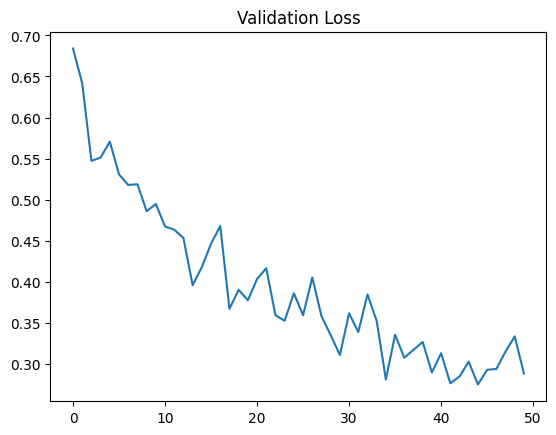

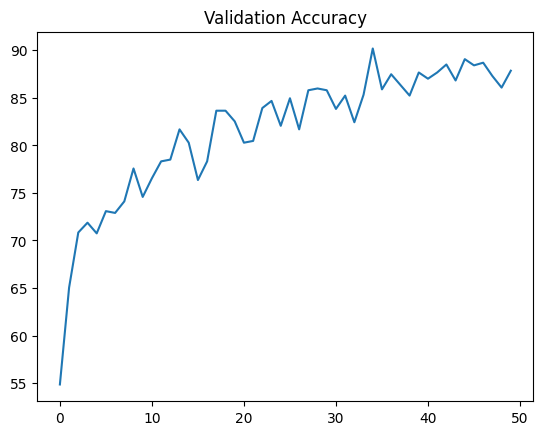

In [ ]:
print(validation_loss_ts)
print(validation_accuracy_ts)
plt.plot(validation_loss_ts)
plt.title("Validation Loss")
plt.show()

plt.plot(validation_accuracy_ts)
plt.title("Validation Accuracy")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
def test_model(threshold):
  # Set the model to evaluation mode
  model.eval()
  test_loss = 0.0
  correct = 0
  total = 0
  # Get the total number of testing samples
  testing_size = len(test_data_loader.dataset)
  predicted_class = []
  actual_class = []

  with torch.no_grad():
      training_batch = 0
      # Iterate over the test data
      for inputs, labels in test_data_loader:
          # Move inputs and labels to the specified device
          inputs, labels = inputs.to(device), labels.to(device)
          inputs = inputs.float()
          labels = labels.float()
          # Forward pass (with batch size of 1)
          outputs = model(inputs.unsqueeze(0))

          # Compute the loss
          loss = loss_function(outputs.squeeze(), labels)

          # Accumulate the test loss
          test_loss += loss.item()

          # Get the predicted class

          predicted = (outputs > threshold).float()

          total += labels.size(0)

          predicted = predicted.view(-1)
          correct += (predicted == labels).sum().item()

          # Store actual and predicted classes
          actual_class.extend(labels.tolist())
          predicted_class.extend(predicted.tolist())

          # Count correct predictions
          training_batch += len(inputs)
          #print(f"test loss: {loss:>7f}  Batch: [{training_batch:>5d}/{testing_size:>5d}]")
  return test_loss, correct, total, predicted_class, actual_class

all_predicted_probs = []
all_actual_labels = []
thresholds = np.arange(0, 1, 0.01)

TPR = []
FPR = []
accuracies = []

for i in thresholds:
  print(f"Threshold: {i}")
  test_loss, correct, total, predicted_class, actual_class = test_model(i)
  tn, fp, fn, tp = confusion_matrix(actual_class, predicted_class).ravel()
  tpr = tp/(tp+fn)
  fpr = fp/(fp + tn)
  TPR.append(tpr)
  FPR.append(fpr)
  acc = correct/total
  #print(f"Accuracy: {acc}")
  accuracies.append((acc, i))




Threshold: 0.0
Threshold: 0.01
Threshold: 0.02
Threshold: 0.03
Threshold: 0.04
Threshold: 0.05
Threshold: 0.06
Threshold: 0.07
Threshold: 0.08
Threshold: 0.09
Threshold: 0.1
Threshold: 0.11
Threshold: 0.12
Threshold: 0.13
Threshold: 0.14
Threshold: 0.15
Threshold: 0.16
Threshold: 0.17
Threshold: 0.18
Threshold: 0.19
Threshold: 0.2
Threshold: 0.21
Threshold: 0.22
Threshold: 0.23
Threshold: 0.24
Threshold: 0.25
Threshold: 0.26
Threshold: 0.27
Threshold: 0.28
Threshold: 0.29
Threshold: 0.3
Threshold: 0.31
Threshold: 0.32
Threshold: 0.33
Threshold: 0.34
Threshold: 0.35000000000000003
Threshold: 0.36
Threshold: 0.37
Threshold: 0.38
Threshold: 0.39
Threshold: 0.4
Threshold: 0.41000000000000003
Threshold: 0.42
Threshold: 0.43
Threshold: 0.44
Threshold: 0.45
Threshold: 0.46
Threshold: 0.47000000000000003
Threshold: 0.48
Threshold: 0.49
Threshold: 0.5
Threshold: 0.51
Threshold: 0.52
Threshold: 0.53
Threshold: 0.54
Threshold: 0.55
Threshold: 0.56
Threshold: 0.5700000000000001
Threshold: 0.58
Thr

In [ ]:
print(FPR)
print(TPR)

(0.0, 0.0018315018315018315, 0.001838235294117647, 0.0019342359767891683, 0.00390625, 0.007207207207207207, 0.0078125, 0.012681159420289856, 0.014344262295081968, 0.016791044776119403, 0.026022304832713755, 0.0260707635009311, 0.029411764705882353, 0.030418250950570342, 0.032567049808429116, 0.03377110694183865, 0.03383458646616541, 0.034990791896869246, 0.04267161410018553, 0.05075187969924812, 0.050816696914700546, 0.051233396584440226, 0.06533575317604355, 0.06563706563706563, 0.06653620352250489, 0.07678571428571429, 0.08052434456928839, 0.08224299065420561, 0.0825515947467167, 0.08365019011406843, 0.08630393996247655, 0.08918406072106262, 0.09140767824497258, 0.09487666034155598, 0.09665427509293681, 0.09925093632958802, 0.10037174721189591, 0.1125, 0.11428571428571428, 0.11552346570397112, 0.11654135338345864, 0.11721611721611722, 0.12237093690248566, 0.1298932384341637, 0.1299638989169675, 0.13102119460500963, 0.1320754716981132, 0.13358778625954199, 0.13493530499075784, 0.13898

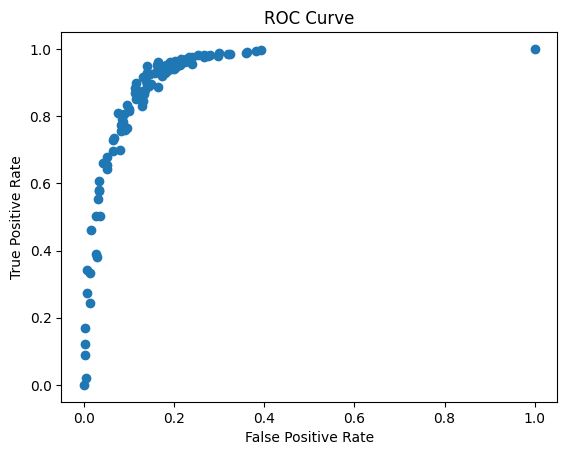

[(0.502803738317757, 0.0), (0.797196261682243, 0.01), (0.8074766355140187, 0.02), (0.8158878504672897, 0.03), (0.8205607476635514, 0.04), (0.8252336448598131, 0.05), (0.8345794392523365, 0.06), (0.8514018691588785, 0.07), (0.8588785046728972, 0.08), (0.8523364485981308, 0.09), (0.8579439252336448, 0.1), (0.8542056074766355, 0.11), (0.8392523364485981, 0.12), (0.8635514018691589, 0.13), (0.874766355140187, 0.14), (0.8588785046728972, 0.15), (0.874766355140187, 0.16), (0.8700934579439252, 0.17), (0.8598130841121495, 0.18), (0.8635514018691589, 0.19), (0.8700934579439252, 0.2), (0.8878504672897196, 0.21), (0.8728971962616823, 0.22), (0.883177570093458, 0.23), (0.8813084112149533, 0.24), (0.8738317757009346, 0.25), (0.8700934579439252, 0.26), (0.905607476635514, 0.27), (0.8803738317757009, 0.28), (0.8794392523364486, 0.29), (0.8962616822429906, 0.3), (0.897196261682243, 0.31), (0.8654205607476636, 0.32), (0.8757009345794392, 0.33), (0.8906542056074767, 0.34), (0.874766355140187, 0.35000000

In [ ]:
# Plot the ROC curve
# from scipy.interpolate import make_interp_spline
# sorted_data = sorted(zip(FPR, TPR), key=lambda x: x[0])
# FPR, TPR = zip(*sorted_data)

# x_smooth = np.linspace(min(FPR), max(FPR), 300)
# spl = make_interp_spline(FPR, TPR, k=3)
# y_smooth = spl(x_smooth)


plt.scatter(FPR, TPR)
#plt.plot(x_smooth, y_smooth)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()


# Calculate the accuracy of the model on the test set
print(accuracies)
optimal_accuracy, optimal_threshold = max(accuracies, key=lambda x: x[0])
test_accuracy = 100 * optimal_accuracy

# Print out the final test loss and accuracy
print(f"Test Accuracy: {test_accuracy:.2f}%")

print(actual_class)
print(predicted_class)

# Compute the confusion matrix using the actual and predicted classes
conf_mat = confusion_matrix(actual_class, predicted_class)

# Print out the confusion matrix
print(conf_mat)

In [ ]:
res = requests.get("https://paleo-data.s3.amazonaws.com/data.csv")
T_df = pd.read_csv(StringIO(res.text), sep=",")

res = requests.get("https://paleo-data.s3.amazonaws.com/main_weather.csv")
W_df = pd.read_csv(StringIO(res.text), sep=",")
W_df.drop_duplicates(subset = ['year', 'lat', 'lon'],
                                      inplace = True,
                                      ignore_index = True)


In [ ]:
model.eval()
test_data_len = train_dataset.__len__()

while True:
  rand_test_point = random.randint(0, test_data_len)
  input, label = train_dataset.__getitem__(rand_test_point)
  if label == 1:
    break

target_temperature = input[51].item()
location_data = W_df[(W_df['year'] == 1941) & (W_df['temperature_avg'] == target_temperature)]
true_lat = location_data['lat'].item()
true_lon = location_data['lon'].item()
rings = input[0:51]


selected_rows = W_df[['lat', 'lon']].drop_duplicates()


heatmap = []

for index, row in selected_rows.iterrows():
    lat = row['lat']
    lon = row['lon']
    weather_data = W_df[(W_df['lat'] == lat) & (W_df['lon'] == lon)]
    temp = torch.tensor(weather_data['temperature_avg'].values)
    precip = torch.tensor(weather_data['precipitation_avg'].values)
    input = torch.cat((rings, temp, precip))
    input = input.to(device)
    input = input.float()
    if len(input) == 153:
      output = model(input)
      heatmap.append((lat, lon, output.item()))



In [ ]:
import folium
from folium.plugins import HeatMap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

confidence_threshold = .5

columns = ['lat', 'lon', 'confidence']


heatmap_df = pd.DataFrame(heatmap, columns=columns)
heatmap_df.loc[heatmap_df['confidence'] > confidence_threshold, 'confidence'] = 1
heatmap_df.loc[heatmap_df['confidence'] <= confidence_threshold, 'confidence'] = 0

print(heatmap_df)



my_map = folium.Map()

folium.Marker(location=[true_lat, true_lon], popup="Given Location").add_to(my_map)

HeatMap(heatmap_df).add_to(my_map)

my_map



NameError: ignored